## Causal Impact Analysis of Media Campaign on Sales

### Bayesian structure time series modeling (BSTS) using pybuc

Google has an R package called [CausalImapct](https://google.github.io/CausalImpact/CausalImpact.html) can estimate the causal effect of a designed intervention on a time series. I love it but the Python version is somewhat lack of flexibility (e.g., the underlying UnobservedComponents model from statsmodels package is not Bayesian). I recently discrovered a Python Bayesian Unobserved Components library ([pybuc](https://pypi.org/project/pybuc/)), which is an implenmentation of R's Bayesian structural time series package ([bsts](https://cran.r-project.org/web/packages/bsts/bsts.pdf)) can do the BSTS modeling for causal impact analysis.
Alternatively, PyMC now has experimental support for linear, Gaussian state space time series models via the pymc_experimental.statespace module. Here is the [link](https://discourse.pymc.io/t/pymc-experimental-now-includes-state-spaces-models/12773).

The marketing team recently conducted a media campaign on a product ABC and would like to know the effectiveness of that campaign (e,g., impact on sales) in the post intervention period. The goal of this study is to examine the causal impact of the campaign in a relatively short period and suggest strategies on media sepnd. As a result, positive causal impact of the campaign on sales was idnetified during the post intervention period.

**Data** : target: sales; covaraites: three types of media spend and holiday

pre-period: Jan 01, 2022-Aug 31, 2023

post-period: Sept 01, 2023-Dec 31,2023


In [2]:
#!pip install pybuc

In [13]:
from pybuc import buc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import r2_score

### Generate sales and media spend data

In [49]:


# Define start and end dates

np.random.seed(123)

start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2022-12-31')

# Randomly select a product launch date within 2023
product_launch_date = start_date #+ pd.Timedelta(days=np.random.randint(0, 365))

# Randomly select a product end date within 2023
product_end_date = end_date #- pd.Timedelta(days=np.random.randint(0, 365))

# Create dates range from launch to end_date
timestamps = pd.date_range(start=product_launch_date, end=product_end_date, freq='D')
n_days = len(timestamps)

# Create a DataFrame for each product
df = pd.DataFrame({
    'Date': timestamps,
    'Sales': np.zeros(n_days),
    'Media_YouTube': np.zeros(n_days),
    'Media_Amazon': np.zeros(n_days),
    'Media_TikTok': np.zeros(n_days)
})

# Define sales patterns for each phase
intro_growth = np.linspace(10, 100, num=int(n_days*1/6))
growth = np.linspace(100, 1000 + np.random.randint(0, 200), num=int(n_days*1/3))  # Randomize max sales
maturity = np.linspace(1000 + np.random.randint(0, 200), 900, num=int(n_days*1/6))
decline = np.linspace(900, 500, num=n_days - len(intro_growth) - len(growth) - len(maturity))

# Combine the sales patterns
sales = np.concatenate([intro_growth, growth, maturity, decline])

# Apply the sales pattern to the DataFrame
df['Sales'] = sales


# Create periods of activity and inactivity for media spend
def create_media_spend_pattern(n_days, min_on=10, max_on=30, min_off=30, max_off=90, spend_range=(100, 300)):
    pattern = np.zeros(n_days)
    current_day = 0
    while current_day < n_days:
        on_period = np.random.randint(min_on, max_on)
        off_period = np.random.randint(min_off, max_off)
        end_on_period = min(current_day + on_period, n_days)
        pattern[current_day:end_on_period] = np.random.uniform(spend_range[0], spend_range[1], end_on_period - current_day)
        current_day = end_on_period + off_period
    return pattern

# Generate media spend patterns for each channel
df['Media_YouTube'] = create_media_spend_pattern(n_days)
df['Media_Amazon'] = create_media_spend_pattern(n_days)
df['Media_TikTok'] = create_media_spend_pattern(n_days)



# Increase sales when media is on
media_active_index = (df['Media_YouTube'] > 0) | (df['Media_Amazon'] > 0) | (df['Media_TikTok'] > 0)
df.loc[media_active_index, 'Sales'] *= 1.1  # Increase by 10% when any media is active

# Add slight day-to-day sales variability
df['Sales'] += np.random.normal(0, 50, size=n_days)
df['Sales'] = df['Sales'].clip(lower=0)


# Create an index to apply holiday effects
holiday_index = df['Date'].apply(lambda x: x.month in [12, 1, 7] and x.day in [1, 4, 23, 30])

# Increase sales on holidays by a factor (e.g., 1.2)
df.loc[holiday_index, 'Sales'] *= 1.2

# Round sales to integer values
df['Sales'] = df['Sales'].round(0).astype(int)
df['Holiday'] = np.where(holiday_index, 1, 0)

# Add the DataFrame to the list

df.head()


,Date,Sales,Media_YouTube,Media_Amazon,Media_TikTok,Holiday
0,2022-01-01,0,238.176971,204.231886,163.028605,1
1,2022-01-02,48,243.830062,216.126404,198.302128,0
2,2022-01-03,0,198.223787,161.839800,264.028408,0
3,2022-01-04,68,256.005552,283.976525,126.524091,1
4,2022-01-05,0,182.184875,231.069501,124.261896,0


In [74]:
import numpy as np
import pandas as pd

np.random.seed(123)

# Function to create media spend pattern
def create_media_spend_pattern(n_days, min_on=10, max_on=30, min_off=30, max_off=90, spend_range=(100, 300)):
    pattern = np.zeros(n_days)
    current_day = 0
    while current_day < n_days:
        on_period = np.random.randint(min_on, max_on)
        off_period = np.random.randint(min_off, max_off)
        end_on_period = min(current_day + on_period, n_days)
        pattern[current_day:end_on_period] = np.random.uniform(spend_range[0], spend_range[1], end_on_period - current_day)
        current_day = end_on_period + off_period
    return pattern

# Function to create sales data with similar pattern
def create_sales_data(start_date, end_date):
    # Create dates range
    timestamps = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(timestamps)

    # Create a DataFrame
    df = pd.DataFrame({
        'Date': timestamps,
        'Sales': np.zeros(n_days),
        'Media_YouTube': np.zeros(n_days),
        'Media_Amazon': np.zeros(n_days),
        'Media_TikTok': np.zeros(n_days)
    })

    # Define sales patterns for each phase
    intro_growth = np.linspace(10, 100, num=int(n_days*1/6))
    growth = np.linspace(100, 1000 + np.random.randint(0, 200), num=int(n_days*1/3))
    maturity = np.linspace(1000 + np.random.randint(0, 200), 900, num=int(n_days*1/6))
    decline = np.linspace(900, 500, num=n_days - len(intro_growth) - len(growth) - len(maturity))

    # Combine the sales patterns
    sales = np.concatenate([intro_growth, growth, maturity, decline])

    # Apply the sales pattern to the DataFrame
    df['Sales'] = sales

    # Generate media spend patterns for each channel
    df['Media_YouTube'] = create_media_spend_pattern(n_days)
    df['Media_Amazon'] = create_media_spend_pattern(n_days)
    df['Media_TikTok'] = create_media_spend_pattern(n_days)

    # Increase sales when media is on
    media_active_index = (df['Media_YouTube'] > 0) | (df['Media_Amazon'] > 0) | (df['Media_TikTok'] > 0)
    df.loc[media_active_index, 'Sales'] *= 1.1  # Increase by 10% when any media is active

    # Add slight day-to-day sales variability
    df['Sales'] += np.random.normal(0, 50, size=n_days)
    df['Sales'] = df['Sales'].clip(lower=0)

    # Create an index to apply holiday effects
    holiday_index = df['Date'].apply(lambda x: x.month in [12, 1, 7] and x.day in [1, 4, 23, 30])

    # Increase sales on holidays by a factor (e.g., 1.2)
    df.loc[holiday_index, 'Sales'] *= 1.2

    # Round sales to integer values
    df['Sales'] = df['Sales'].round(0).astype(int)
    df['Holiday'] = np.where(holiday_index, 1, 0)

    return df

# Generate 2022 data
df_2022 = create_sales_data(start_date='2022-01-01', end_date='2022-12-31')

# Generate 2023 data with similar pattern
df_2023 = create_sales_data(start_date='2023-01-01', end_date='2023-12-31')

# Concatenate both dataframes
df_all = pd.concat([df_2022, df_2023]).reset_index(drop=True)

df_all.head()



,Date,Sales,Media_YouTube,Media_Amazon,Media_TikTok,Holiday
0,2022-01-01,0,238.176971,204.231886,163.028605,1
1,2022-01-02,48,243.830062,216.126404,198.302128,0
2,2022-01-03,0,198.223787,161.839800,264.028408,0
3,2022-01-04,68,256.005552,283.976525,126.524091,1
4,2022-01-05,0,182.184875,231.069501,124.261896,0


### Generate campaign effect

In [75]:
df=df_all.copy()
campaign_start = pd.Timestamp('2023-09-01')
campaign_end = pd.Timestamp('2023-11-30')

campaign_index = df['Date'].between(campaign_start, campaign_end)
df.loc[campaign_index, 'Sales'] *= 1.3
df.loc[campaign_index, 'Sales'] = df.loc[campaign_index, 'Sales'].round(0).astype(int)

df.index=df.Date
df.drop('Date', axis=1,inplace=True)

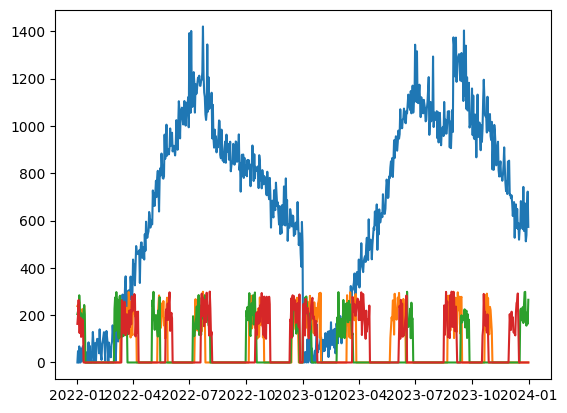

In [76]:
plt.plot(df['Sales'])
plt.plot(df['Media_YouTube'])
plt.plot(df['Media_Amazon'])
plt.plot(df['Media_TikTok'])

In [77]:
pre_period_df=df[df.index<campaign_start]
post_period_df=df[df.index>=campaign_start]

In [78]:
pre_period_df

,Sales,Media_YouTube,Media_Amazon,Media_TikTok,Holiday
Date,,,,,
2022-01-01,0.0,238.176971,204.231886,163.028605,1
2022-01-02,48.0,243.830062,216.126404,198.302128,0
2022-01-03,0.0,198.223787,161.839800,264.028408,0
2022-01-04,68.0,256.005552,283.976525,126.524091,1
2022-01-05,0.0,182.184875,231.069501,124.261896,0
...,...,...,...,...,...
2023-08-27,1018.0,134.894632,0.000000,284.395794,0
2023-08-28,906.0,175.613917,0.000000,150.727057,0
2023-08-29,986.0,214.074823,0.000000,299.313826,0


### Generate pre- and post- internvetion data for modeling

In [79]:

scaler = MinMaxScaler()

pre_period_df1 = pre_period_df.drop(columns='Sales')
# Fitting and transforming the data
pre_period_df_s = scaler.fit_transform(pre_period_df1)

# Convert back to DataFrame if needed
pre_period_df_s = pd.DataFrame(pre_period_df_s, columns=pre_period_df1.columns)
pre_period_df_s['Sales'] = pre_period_df['Sales'].values
pre_period_df_s.index=pre_period_df.index


In [80]:
post_period_df1 = post_period_df.drop(columns='Sales')
post_period_df_s = scaler.transform(post_period_df1)

# Convert back to DataFrame if needed
post_period_df_s = pd.DataFrame(post_period_df_s, columns=post_period_df1.columns)
post_period_df_s['Sales'] = post_period_df['Sales'].values
post_period_df_s.index=post_period_df.index

In [81]:
post_period_df_s

,Media_YouTube,Media_Amazon,Media_TikTok,Holiday,Sales
Date,,,,,
2023-09-01,1.000207,0.000000,0.995877,0.0,1374.0
2023-09-02,0.345127,0.000000,0.913586,0.0,1340.0
2023-09-03,0.920613,0.000000,0.443930,0.0,1310.0
2023-09-04,0.609021,0.000000,0.457497,0.0,1208.0
2023-09-05,0.911516,0.000000,0.787852,0.0,1373.0
...,...,...,...,...,...
2023-12-27,0.000000,0.581632,0.000000,0.0,512.0
2023-12-28,0.000000,0.520855,0.000000,0.0,538.0
2023-12-29,0.000000,0.705497,0.000000,0.0,669.0


### Build customized BSTS model

In [83]:
bayes_uc = buc.BayesianUnobservedComponents(response=pre_period_df_s['Sales'],predictors=pre_period_df_s.drop('Sales',axis=1),
                                            level=True, stochastic_level=True,
                                            trend=True, stochastic_trend=True,
                                            trig_seasonal=((30, 1),), stochastic_trig_seasonal=(True,),
                                            seed=123)

In [84]:
pre_period_df_s

,Media_YouTube,Media_Amazon,Media_TikTok,Holiday,Sales
Date,,,,,
2022-01-01,0.796957,0.683505,0.544161,1.0,0.0
2022-01-02,0.815873,0.723312,0.661898,0.0,48.0
2022-01-03,0.663271,0.541631,0.881281,0.0,0.0
2022-01-04,0.856613,0.950387,0.422316,1.0,68.0
2022-01-05,0.609604,0.773323,0.414765,0.0,0.0
...,...,...,...,...,...
2023-08-27,0.451367,0.000000,0.949264,0.0,1018.0
2023-08-28,0.587617,0.000000,0.503101,0.0,906.0
2023-08-29,0.716310,0.000000,0.999058,0.0,986.0


In [141]:
reg_coeff_mean_prior=[1]*3+[0.5]



In [87]:
post = bayes_uc.sample(1000, level_var_shape_prior=100,reg_coeff_mean_prior=reg_coeff_mean_prior,zellner_prior_obs=10,
                       max_samp_iter_factor=500)

In [88]:
mcmc_burn = 100

for key, value in bayes_uc.summary(burn=mcmc_burn).items():
    if 'Posterior.Mean' in key:
        print(key, ' : ', value)

Posterior.Mean[Irregular.Var]  :  2373.5044814239077
Posterior.Mean[Level.Var]  :  0.14838582113858878
Posterior.Mean[Trend.Var]  :  3.381224470223551
Posterior.Mean[Trig-Seasonal.30.1.Var]  :  657.9431841797903
Posterior.Mean[Coeff.Media_YouTube]  :  -10.606757028503036
Posterior.Mean[Coeff.Media_Amazon]  :  -29.153121116375676
Posterior.Mean[Coeff.Media_TikTok]  :  4.7461174751085045
Posterior.Mean[Coeff.Holiday]  :  123.21090958592252


In [89]:

def rmse(actual, prediction):
    act, pred = actual.flatten(), prediction.flatten()
    return np.sqrt(np.mean((act - pred) ** 2))


bayes_uc.posterior
posterior_mean = np.mean(bayes_uc.posterior[3], axis=0) #smoothed predictions
print(f"R2 score: {r2_score(pre_period_df.Sales.to_numpy(), posterior_mean)}")

R2 score: 0.9903607269584487


In [90]:
bayes_uc.posterior[4].shape

(1000, 609, 5, 1)

In [156]:
bayes_uc.posterior[4].shape
# Discard the first 100 draws
posterior_filtered = bayes_uc.posterior[4][100:, :,: , :]

# Calculate the mean of the filtered posterior prediction
posterior_mean = posterior_filtered.mean(axis=(0, 2))[1:]
#print(f"R2 score: {r2_score(pre_period_df_s.Sales.to_numpy(), posterior_mean)}")


Number of posterior samples (after burn)  :  900
Posterior.Mean[Irregular.Var]  :  2373.5044814239077
Posterior.StdDev[Irregular.Var]  :  729.6000181002283
Posterior.CredInt.LB[Irregular.Var]  :  50.58238883375843
Posterior.CredInt.UB[Irregular.Var]  :  2978.470481083815
Posterior.Mean[Level.Var]  :  0.14838582113858878
Posterior.StdDev[Level.Var]  :  0.01507545752146381
Posterior.CredInt.LB[Level.Var]  :  0.12185940075553447
Posterior.CredInt.UB[Level.Var]  :  0.18305190670611482
Posterior.Mean[Trend.Var]  :  3.381224470223551
Posterior.StdDev[Trend.Var]  :  2.035352079202784
Posterior.CredInt.LB[Trend.Var]  :  0.6801251708987973
Posterior.CredInt.UB[Trend.Var]  :  7.580559218520694
Posterior.Mean[Trig-Seasonal.30.1.Var]  :  657.9431841797903
Posterior.StdDev[Trig-Seasonal.30.1.Var]  :  1399.9437865531975
Posterior.CredInt.LB[Trig-Seasonal.30.1.Var]  :  120.78868540645416
Posterior.CredInt.UB[Trig-Seasonal.30.1.Var]  :  5451.299766893685
Posterior.Mean[Coeff.Media_YouTube]  :  -10.606

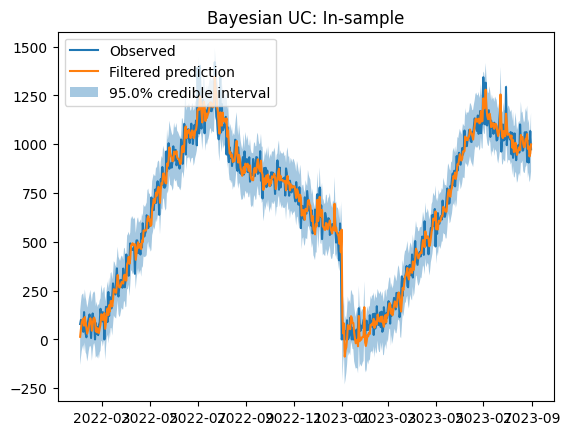

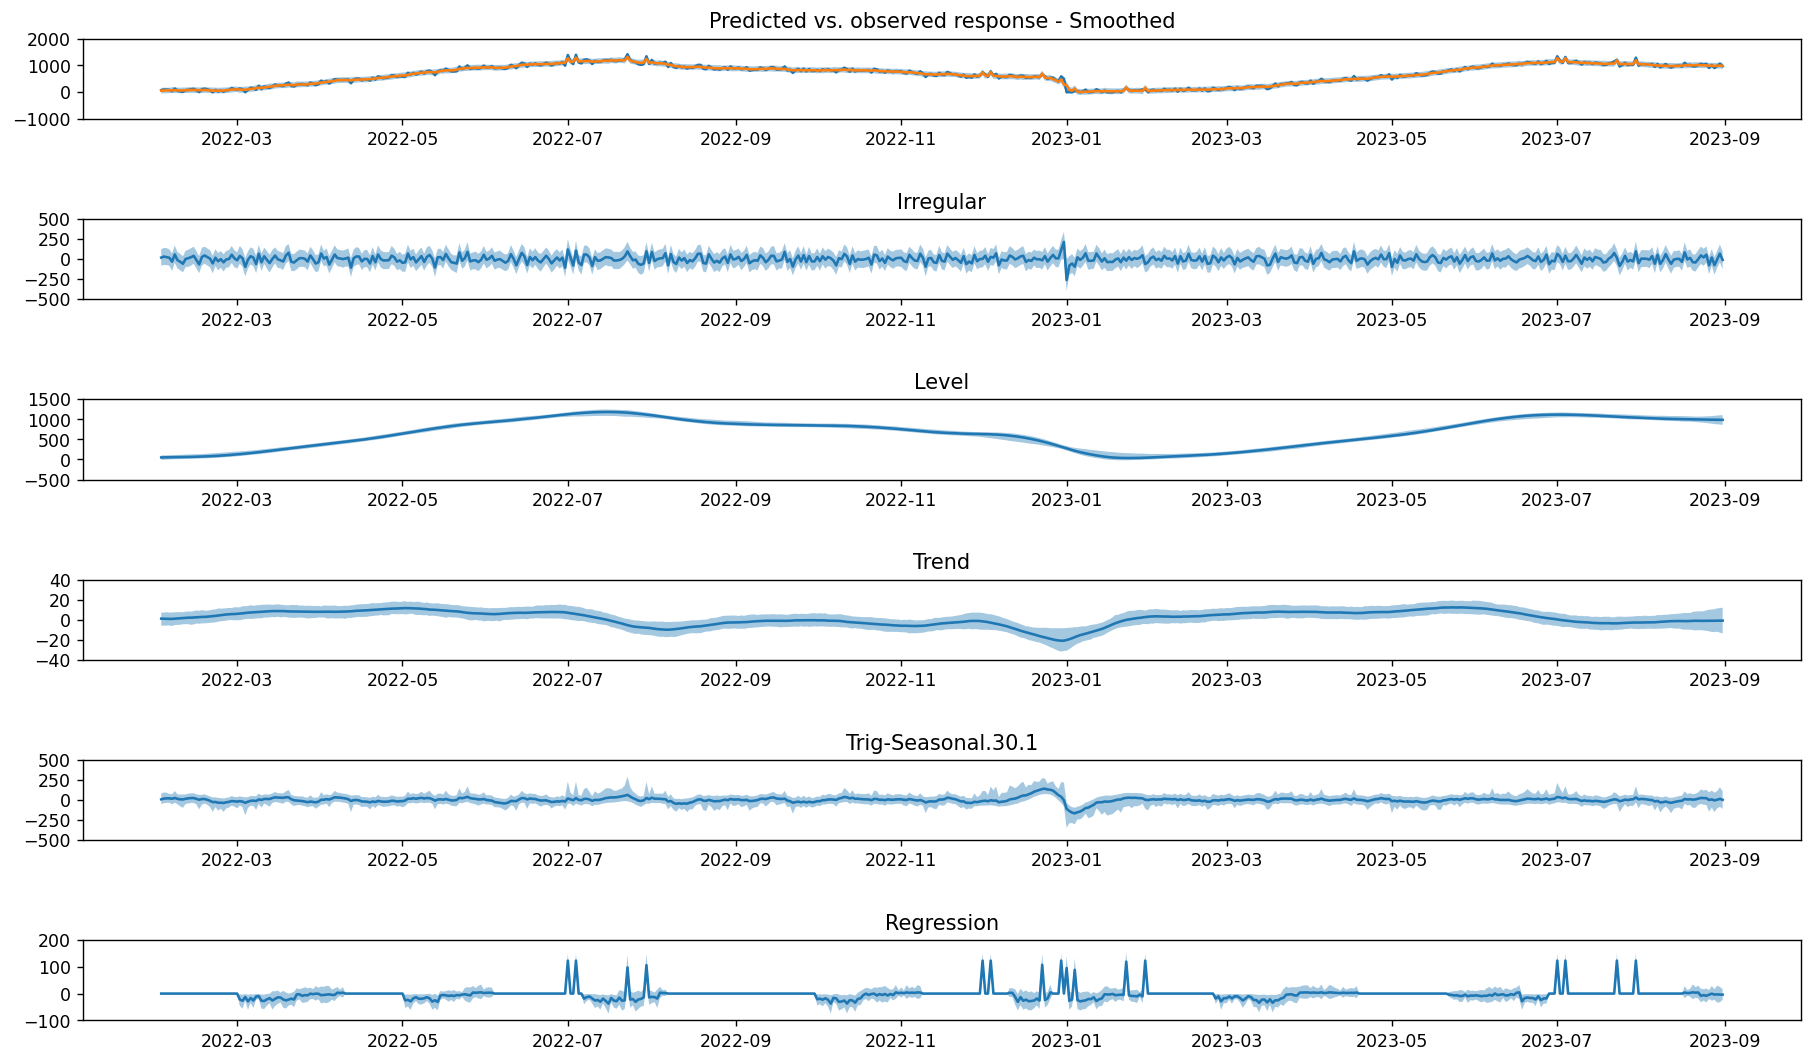

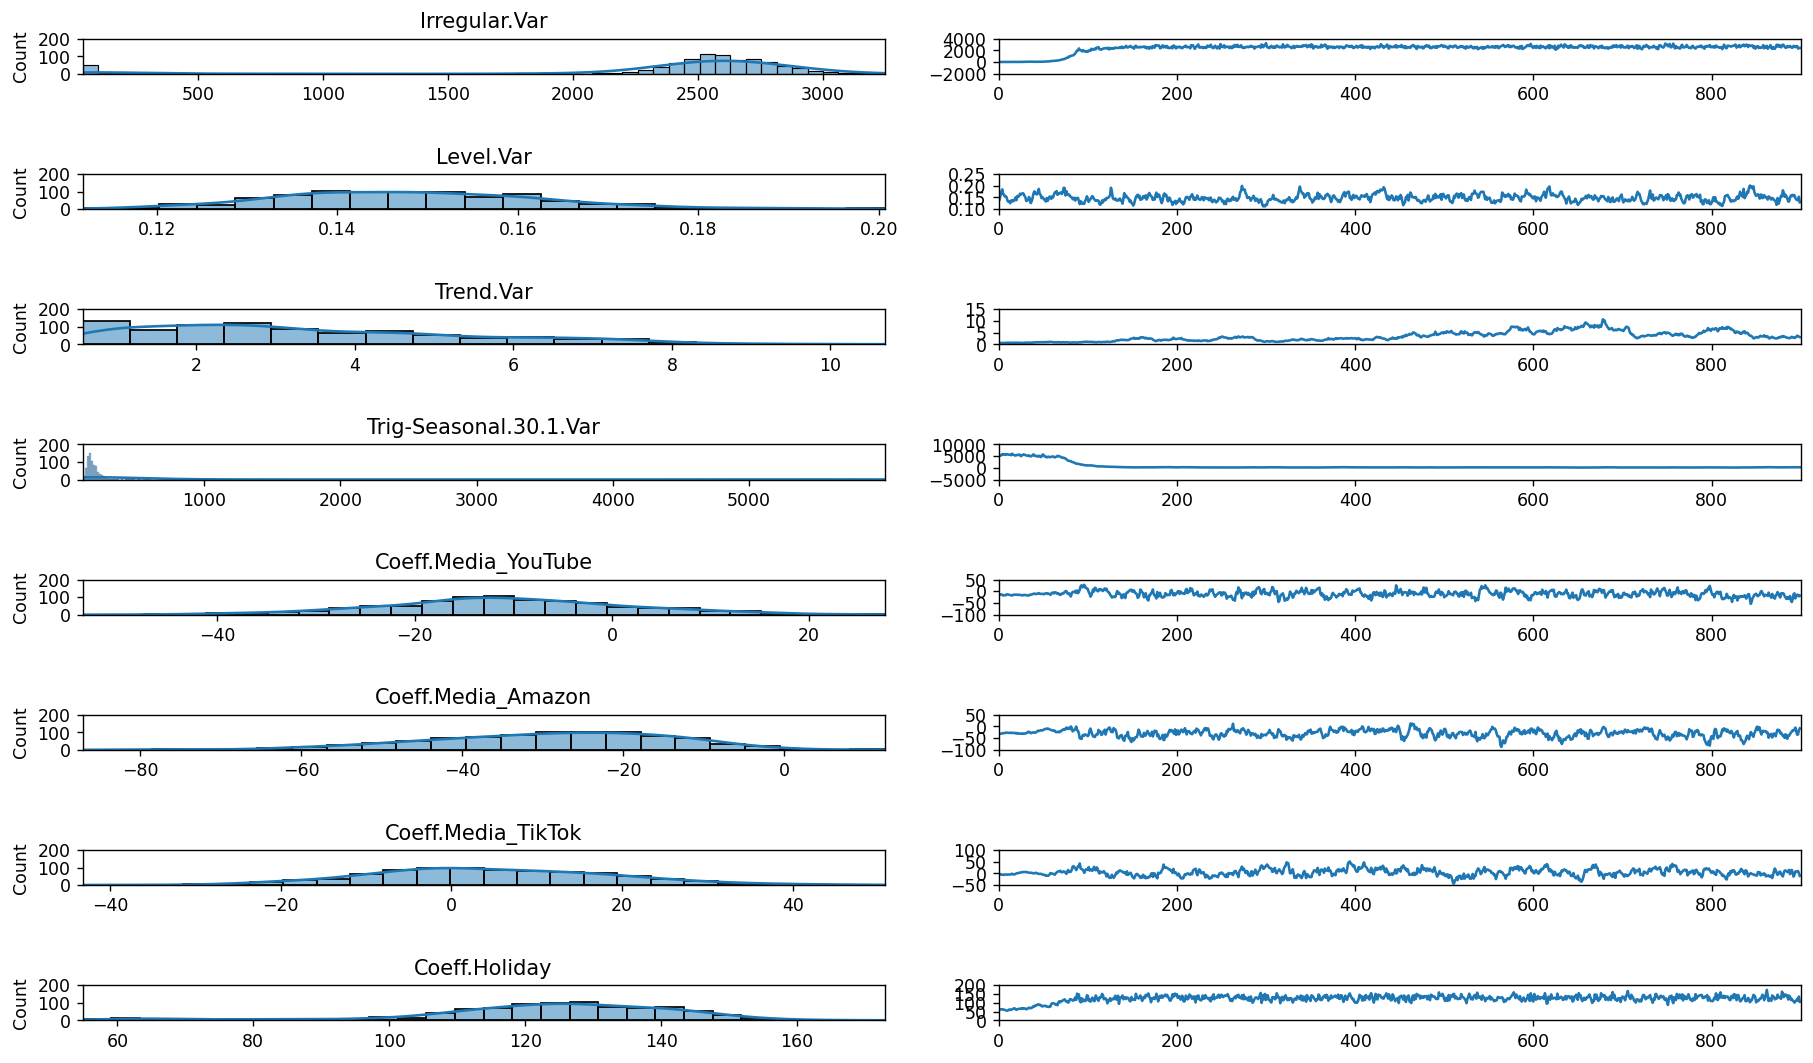

In [92]:
mcmc_burn = 100

# Print summary of estimated parameters
for key, value in bayes_uc.summary(burn=mcmc_burn).items():
    print(key, ' : ', value)

# Plot in-sample fit against actuals
bayes_uc.plot_post_pred_dist(burn=mcmc_burn)
plt.title('Bayesian UC: In-sample')
plt.show()

# Plot time series components
bayes_uc.plot_components(burn=mcmc_burn, smoothed=True)
plt.show()

# Plot trace of posterior
bayes_uc.plot_trace(burn=mcmc_burn)
plt.show()



### Post interventio inference

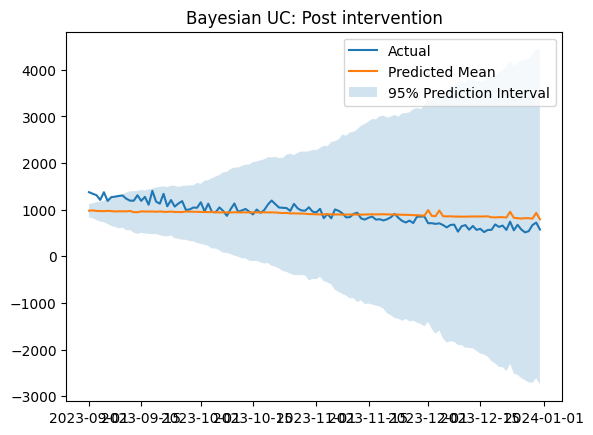

BAYES-UC RMSE: 193.01201778613867
R2 score: 0.2987308646260105


In [99]:
from sklearn.metrics import r2_score
def rmse(actual, prediction):
    act, pred = actual.flatten(), prediction.flatten()
    return np.sqrt(np.mean((act - pred) ** 2))

# Get and plot forecast
forecast, _ =bayes_uc.forecast(post_period_df_s.shape[0], future_predictors=post_period_df_s.drop('Sales',axis=1),burn=mcmc_burn)

forecast_mean = np.mean(forecast, axis=0)
forecast_l95 = np.quantile(forecast, 0.025, axis=0).flatten()
forecast_u95 = np.quantile(forecast, 0.975, axis=0).flatten()

plt.plot(post_period_df_s.Sales)
plt.plot(bayes_uc.future_time_index, forecast_mean)
plt.fill_between(bayes_uc.future_time_index, forecast_l95, forecast_u95, alpha=0.2)
plt.title('Bayesian UC: Post intervention')
plt.legend(['Actual', 'Predicted Mean', '95% Prediction Interval'])
plt.show()

# Print RMSE
print(f"BAYES-UC RMSE: {rmse(post_period_df_s.Sales.to_numpy(), forecast_mean)}")

#print R2
print(f"R2 score: {r2_score(post_period_df_s.Sales.to_numpy(), forecast_mean)}")


In [117]:
forecast.shape

forecast_l95 = np.quantile(forecast, 0.025, axis=0)



(122, 1)

In [95]:
post_period_pred=post_period_df_s.copy()
post_period_pred['Sales']=forecast_mean

In [96]:
causalimpact=post_period_df_s.Sales-post_period_pred.Sales
causalimpact

Date
2023-09-01    392.944016
2023-09-02    355.598334
2023-09-03    339.181439
2023-09-04    237.106291
2023-09-05    407.774193
                 ...    
2023-12-27   -290.671808
2023-12-28   -264.552996
2023-12-29   -119.364042
2023-12-30   -190.094590
2023-12-31   -196.715100
Name: Sales, Length: 122, dtype: float64

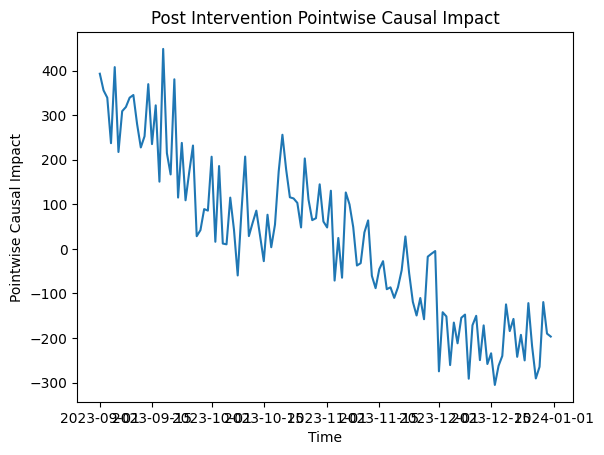

In [139]:
plt.plot(causalimpact)
plt.title('Post Intervention Pointwise Causal Impact')
plt.xlabel('Time')
plt.ylabel('Pointwise Causal Impact')
plt.show()


Date
2023-09-01     392.944016
2023-09-02     748.542350
2023-09-03    1087.723789
2023-09-04    1324.830080
2023-09-05    1732.604272
                 ...     
2023-12-27    3702.059545
2023-12-28    3437.506550
2023-12-29    3318.142507
2023-12-30    3128.047917
2023-12-31    2931.332816
Name: Sales, Length: 122, dtype: float64


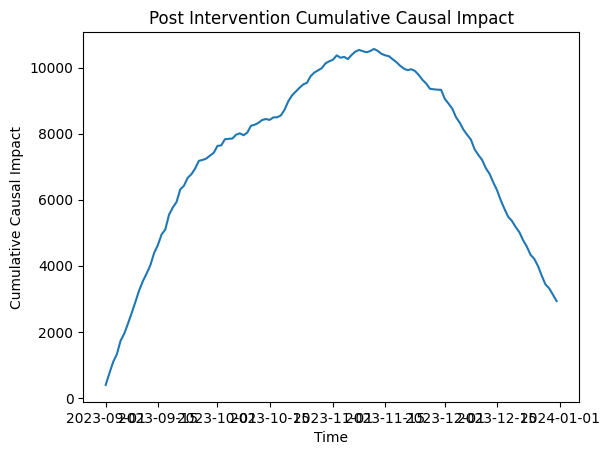

In [101]:
impact_cum=causalimpact.cumsum()
print(impact_cum)
plt.plot(impact_cum)
plt.title('Post Intervention Cumulative Causal Impact')
plt.xlabel('Time')
plt.ylabel('Cumulative Causal Impact')
plt.show()


### Summarize results

In [122]:
post_point_resp = post_period_df_s.Sales.values
mean_resp = post_point_resp.mean()
mean_resp_fmt=int(mean_resp)
cum_resp = post_point_resp.sum()
cum_resp_fmt=int(cum_resp)

post_point_pred=post_period_pred.Sales
mean_pred = post_point_pred.mean()
mean_pred_fmt=int(mean_pred)
cum_pred = post_point_pred.sum()
cum_pred_fmt=int(cum_pred)

post_point_lower = forecast_l95
post_point_upper=forecast_u95
mean_lower = post_point_lower.mean()
mean_lower_fmt = int(mean_lower)
mean_upper = post_point_upper.mean()
mean_upper_fmt = int(mean_upper)
mean_ci_fmt = [mean_lower_fmt, mean_upper_fmt]
cum_lower = post_point_lower.sum()
cum_lower_fmt = int(cum_lower)
cum_upper = post_point_upper.sum()
cum_upper_fmt = int(cum_upper)
cum_ci_fmt = [cum_lower_fmt, cum_upper_fmt]


abs_effect = (post_point_resp - post_point_pred).mean()
abs_effect_fmt = int(abs_effect)
cum_abs_effect = (post_point_resp - post_point_pred).sum()
cum_abs_effect_fmt = int(cum_abs_effect)
abs_effect_lower = (post_point_resp - post_point_lower).mean()
abs_effect_lower_fmt = int(abs_effect_lower)
abs_effect_upper = (post_point_resp - post_point_upper).mean()
abs_effect_upper_fmt = int(abs_effect_upper)
abs_effect_ci_fmt = [abs_effect_lower_fmt, abs_effect_upper_fmt]
cum_abs_lower = (post_point_resp - post_point_lower).sum()
cum_abs_lower_fmt = int(cum_abs_lower)
cum_abs_upper = (post_point_resp - post_point_upper).sum()
cum_abs_upper_fmt = int(cum_abs_upper)
cum_abs_effect_ci_fmt = [cum_abs_lower_fmt, cum_abs_upper_fmt]



rel_effect = abs_effect / mean_pred * 100
rel_effect_fmt = "{:.1f}%".format(rel_effect)
cum_rel_effect = cum_abs_effect / cum_pred * 100
cum_rel_effect_fmt = "{:.1f}%".format(cum_rel_effect)
rel_effect_lower = abs_effect_lower / mean_pred * 100
rel_effect_lower_fmt = "{:.1f}%".format(rel_effect_lower)
rel_effect_upper = abs_effect_upper / mean_pred * 100
rel_effect_upper_fmt = "{:.1f}%".format(rel_effect_upper)
rel_effect_ci_fmt = [rel_effect_lower_fmt, rel_effect_upper_fmt]
cum_rel_effect_lower = cum_abs_lower / cum_pred * 100
cum_rel_effect_lower_fmt = "{:.1f}%".format(cum_rel_effect_lower)
cum_rel_effect_upper = cum_abs_upper / cum_pred * 100
cum_rel_effect_upper_fmt = "{:.1f}%".format(cum_rel_effect_upper)
cum_rel_effect_ci_fmt = [cum_rel_effect_lower_fmt, cum_rel_effect_upper_fmt]

In [125]:
import scipy.stats as st
# assuming approximately normal distribution
        # calculate standard deviation from the 95% conf interval
std_pred = (mean_upper - mean_pred) / 1.96  # from mean_upper = mean_pred + 1.96 * std
        # calculate z score
z_score = (0 - mean_pred) / std_pred
        # pvalue from zscore
p_value = st.norm.cdf(z_score)
prob_causal = 1 - p_value
p_value_perc = p_value * 100
prob_causal_perc = prob_causal * 100

In [126]:
summary = [
                [mean_resp_fmt, cum_resp_fmt],
                [mean_pred_fmt, cum_pred_fmt],
                [mean_ci_fmt, cum_ci_fmt],
                [" ", " "],
                [abs_effect_fmt, cum_abs_effect_fmt],
                [abs_effect_ci_fmt, cum_abs_effect_ci_fmt],
                [" ", " "],
                [rel_effect_fmt, cum_rel_effect_fmt],
                [rel_effect_ci_fmt, cum_rel_effect_ci_fmt],
                [" ", " "],
                ["{:.1f}%".format(p_value_perc), " "],
                ["{:.1f}%".format(prob_causal_perc), " "],
            ]
summary = pd.DataFrame(
                summary,
                columns=["Average", "Cumulative"],
                index=[
                    "Actual",
                    "Predicted",
                    "95% CI",
                    " ",
                    "Absolute Effect",
                    "95% CI",
                    " ",
                    "Relative Effect",
                    "95% CI",
                    " ",
                    "P-value",
                    "Prob. of Causal Effect",
                ],
            )
summary

,Average,Cumulative
Actual,922,112530
Predicted,898,109598
95% CI,"[-702, 2520]","[-85656, 307487]"
,,
Absolute Effect,24,2931
95% CI,"[1624, -1598]","[24178728, -194957]"
,,
Relative Effect,2.7%,2.7%
95% CI,"[180.8%, -177.9%]","[22061.2%, -177.9%]"
,,


In [155]:
confidence = "{}%".format(int((1 - 0.05) * 100))

"""During the post-intervention period, the response variable had an average value of approx. {mean_resp}. In the absence of an intervention, we would have expected an average response of {mean_pred}. The {confidence} interval of this counterfactual prediction is [{mean_lower}, {mean_upper}]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is {abs_effect} with a {confidence} interval of [{abs_lower}, {abs_upper}]. Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of {cum_resp}. Had the intervention not taken place, we would have expected a sum of {cum_pred}. The {confidence} interval of this prediction is [{cum_pred_lower}, {cum_pred_upper}].The above results are given in terms
of absolute numbers. In relative terms, the response variable showed an increase of  {rel_effect}. The {confidence} interval of this percentage is [{rel_effect_lower}, {rel_effect_upper}]. This means that, although the intervention appears to have caused a positive effect, this
effect is not statistically significant when considering the post-intervention period as a whole. Individual days or shorter stretches within the intervention period may of course still have had a significant effect, as indicated whenever the lower limit of the impact time series was above zero.
""".format(mean_resp=mean_resp_fmt,
                mean_pred=mean_pred_fmt,
                confidence=confidence,
                mean_lower=mean_lower_fmt,
                mean_upper=mean_upper_fmt,
                abs_effect=abs_effect_fmt,
                abs_upper=abs_effect_upper_fmt,
                abs_lower=abs_effect_lower_fmt,
                cum_resp=cum_resp_fmt,
                cum_pred=cum_pred_fmt,

                cum_pred_lower=cum_lower_fmt,
                cum_pred_upper=cum_upper_fmt,
                 rel_effect=rel_effect_fmt,
                rel_effect_lower=rel_effect_lower_fmt,
                rel_effect_upper=rel_effect_upper_fmt,
            )

'During the post-intervention period, the response variable had an average value of approx. 922. In the absence of an intervention, we would have expected an average response of 898. The 95% interval of this counterfactual prediction is [-702, 2520]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is 24 with a 95% interval of [1624, -1598]. Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of 112530. Had the intervention not taken place, we would have expected a sum of 109598. The 95% interval of this prediction is [-85656, 307487].The above results are given in terms\nof absolute numbers. In relative terms, the response variable showed an increase of  2.7%. The 95% interval of this percentage is [180.8%, -177.9%]. This means that, although the intervention app